In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import sys
sys.path.append('/remote/tychodata/ftairli/work/Projects/MuonSignal/Models')

In [2]:
plt.rcParams['figure.figsize'] = [15, 12]

In [226]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using Device:', device)

Trace  = torch.load('../Data/NormData/Main_test.pt').mean(dim=1).unsqueeze(1)
Features= torch.load('../Data/NormData/Features_test.pt')

print('Trace Shape:', Trace.shape)
print('Features Shape:', Features.shape)

AverageTrace  = [0.0256, 0.0823, 0.1157, 0.1315, 0.1366, 0.1369, 0.1347, 0.1308, 0.1259,
        0.1205, 0.1146, 0.1086, 0.1028, 0.0970, 0.0913, 0.0858, 0.0805, 0.0756,
        0.0708, 0.0664, 0.0623, 0.0584, 0.0549, 0.0515, 0.0485, 0.0456, 0.0429,
        0.0404, 0.0381, 0.0360, 0.0340, 0.0321, 0.0304, 0.0287, 0.0272, 0.0258,
        0.0245, 0.0233, 0.0222, 0.0211, 0.0201, 0.0191, 0.0182, 0.0173, 0.0165,
        0.0158, 0.0150, 0.0143, 0.0137, 0.0130, 0.0125, 0.0119, 0.0114, 0.0108,
        0.0104, 0.0099, 0.0095, 0.0091, 0.0087, 0.0083, 0.0080, 0.0077, 0.0074,
        0.0071, 0.0068, 0.0065, 0.0062, 0.0060, 0.0058, 0.0055, 0.0053, 0.0050,
        0.0049, 0.0047, 0.0045, 0.0044, 0.0042, 0.0040, 0.0039, 0.0038, 0.0036,
        0.0034, 0.0033, 0.0032, 0.0031, 0.0030, 0.0029, 0.0028, 0.0027, 0.0026,
        0.0025, 0.0024, 0.0023, 0.0022, 0.0021, 0.0021, 0.0020, 0.0019, 0.0018,
        0.0018, 0.0017, 0.0017, 0.0016, 0.0016, 0.0015, 0.0015, 0.0014, 0.0014,
        0.0013, 0.0013, 0.0013, 0.0012, 0.0012, 0.0011, 0.0011, 0.0011, 0.0010,
        0.0010, 0.0010, 0.0009]

Using Device: cuda
Trace Shape: torch.Size([169157, 1, 120])
Features Shape: torch.Size([169157, 12])


In [4]:
Name = 'Model_5_TraceGenerator'
model = torch.load(f'../Models/{Name}.pt')

Tracker = torch.load(f'../Models/{Name}_Tracker.pt')


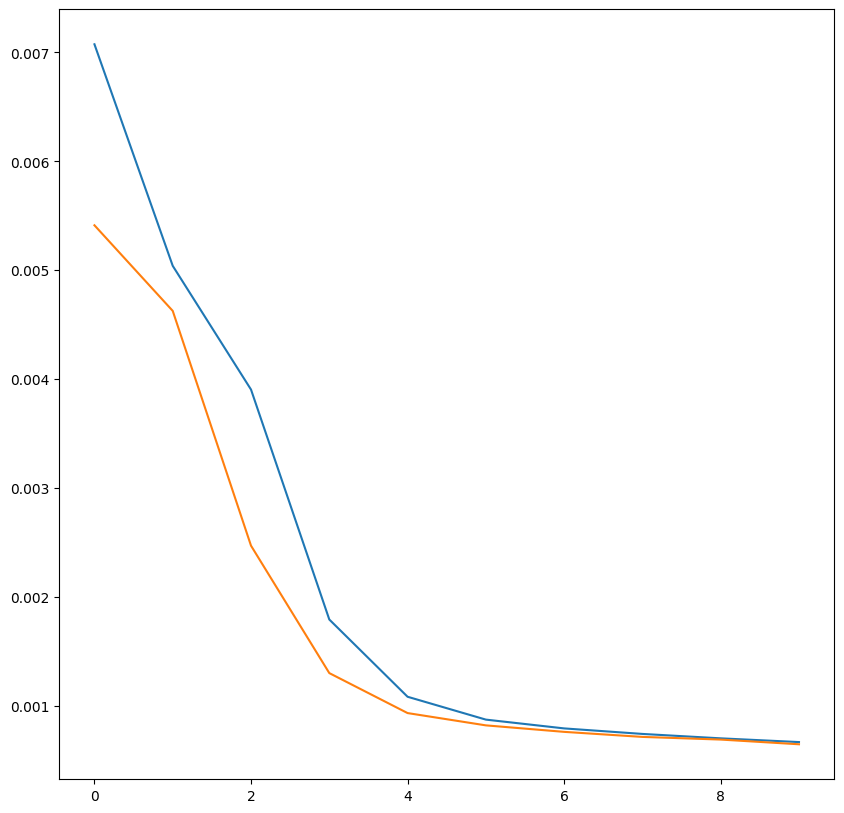

In [5]:
plt.figure(figsize=(10,10))
plt.plot(Tracker.EpochLoss)
plt.plot(Tracker.EpochValLoss)

In [6]:

model = model.to(device)
model.eval()

from Model_5_0 import MyDataset
from torch.utils.data import DataLoader

BatchSize      = 100


test_dataset = MyDataset(Features,Trace)
dataloader_test = DataLoader(test_dataset,batch_size=BatchSize)

pred = np.zeros(shape = [len(Features),120])
truth= np.zeros(shape = [len(Features),120])

filled = 0
BatchN = 0
print('Beginging to compute')
with torch.no_grad():
    for batch_Features,batch_Traces in dataloader_test:

        print(f'\rBatch {BatchN} of {len(dataloader_test)}',end='')

        batch_Features    = batch_Features.to(device)
        batch_Traces      = batch_Traces.to(device)
        Current_BatchSize = batch_Features.shape[0]
        
        Results = model(batch_Features)
        Truths  = batch_Traces
        
        pred[filled: filled+Current_BatchSize] = Results.cpu().numpy().squeeze()
        truth[filled: filled+Current_BatchSize] = Truths.cpu().numpy().squeeze()
        
        filled += Current_BatchSize
        BatchN += 1

# del model

Beginging to compute
Batch 1691 of 1692

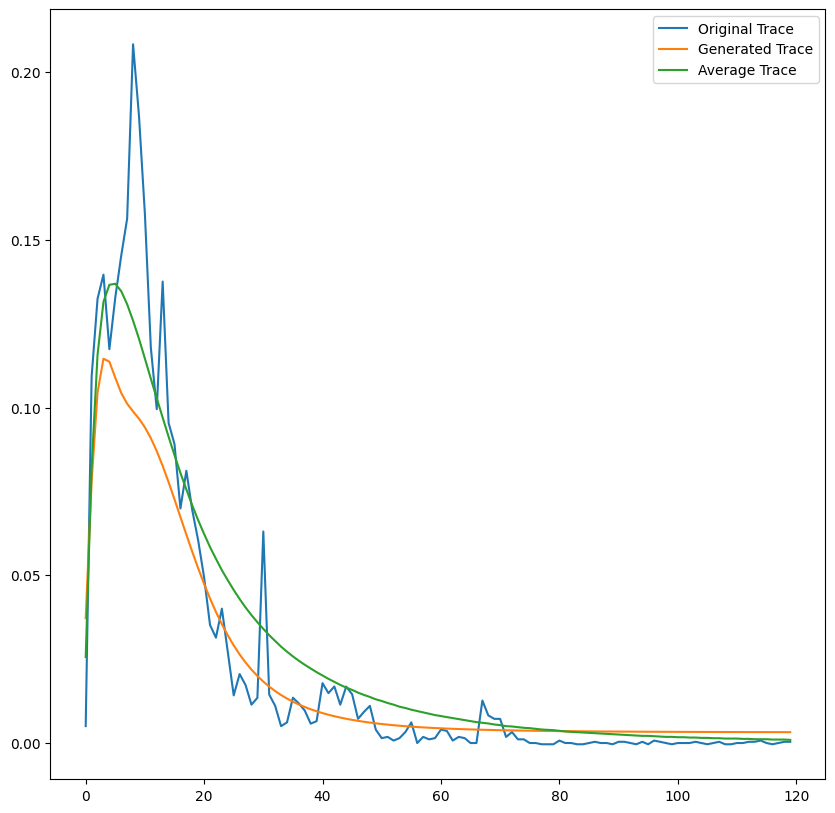

In [276]:
while True:
    N  = np.random.randint(len(Features))
    if np.sum(truth[N]) > 1:
        break
RandomTrace = truth[N]
RandomPred  = pred[N]

plt.figure(figsize=(10,10))
plt.plot(RandomTrace,label = 'Original Trace')
plt.plot(RandomPred,label = 'Generated Trace')
plt.plot(AverageTrace,label = 'Average Trace')
plt.legend()


In [90]:
FOI_mins = Features.min(dim=0)[0]

In [91]:
FOI_maxs = Features.max(dim=0)[0]

Random Trace Shape: (120,)


/tmp/ipykernel_24061/1611283952.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('coolwarm',10)


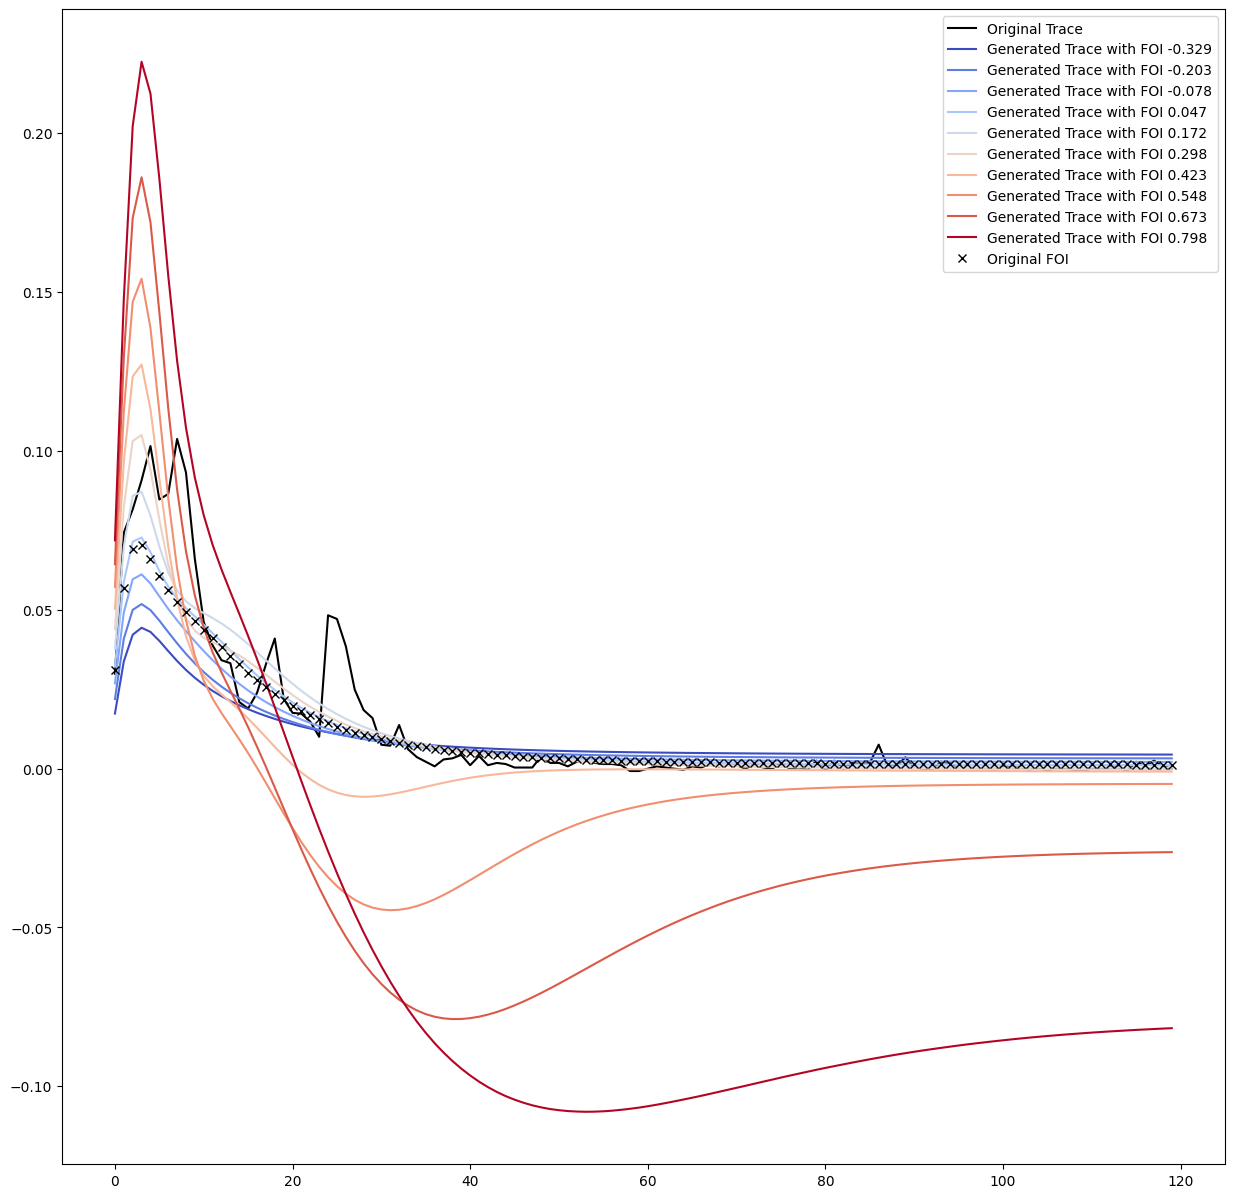

In [321]:

colormap = plt.cm.get_cmap('coolwarm',10)
while True:
    N  = np.random.randint(len(Features))
    if (Trace[N].sum()) > 1:
        break

RandomTrace    = Trace[N].squeeze().numpy()
print('Random Trace Shape:', RandomTrace.shape)
RandomFeatures = Features[N]

FOI = 10
plt.figure(figsize=(15,15))
plt.plot(RandomTrace,'k-',label = 'Original Trace')
originalFOIprediction = model(RandomFeatures.unsqueeze(0).to(device)).cpu().detach().squeeze().numpy()
for i,ReplacedFeature in enumerate(np.linspace(FOI_mins[FOI],FOI_maxs[FOI],10)):
    RandomFeatures[FOI] = ReplacedFeature
    prediction = model(RandomFeatures.unsqueeze(0).to(device)).cpu().detach().squeeze().numpy()


    plt.plot(prediction,label = f'Generated Trace with FOI {ReplacedFeature:.3f}',color = colormap(i/10))
plt.plot(originalFOIprediction,'kx',label = 'Original FOI')
plt.legend()
